# SWMM with Python Week 2: Sensitivity Analysis

Sensitivity analysis is such a big word, I used to say it just to sound smart. 

As I am getting better at modeling I started to appreciate the benefits of doing sensitivity analysis. The most useful form of sensitivity analysis is the casual ones every modeler does on a daily basis, "give it a try and see what happens.", "try a few combinations of the parameters and see what happens."

So you got the idea, at the heart of how we learn something, it is sensitivty analysis. And we are all experts of doing it without even thinking about it.

The challenge when working with swmm models is that the number of factors we need to keep track is way beyond what we can easily remember, so taking a systamatic approach will not only save us time, but also help us learn faster.

Python is a great, with the right libraries I can cut through the tedious part of the learning process, and this week I'll show you how it can be a time saver when doing sensitivity analysis.

## The problem

Recently I am spending a lot time supporting customers running 2D simualtions, and I realized that I need to become an expert on soil infiltration hydrology to better serve my customers. After reading the great [SWMM5 hydrology manual](https://nepis.epa.gov/Exe/ZyPURL.cgi?Dockey=P100NYRA.txt), I got some ideas on the green ampt method. But the equations totally lose me.

I used to get frustrated when I couldn't understand the equations. But later I realized I can still become a great modeler without knowing math that well. It is kind of like knowing the details how mechanically the car control works is almost irrelavent when it comes to driving a car. It is the feel I learned through countless hours of practice that counts. Don't get me wrong, for modelers who are gifted in math, they are so lucky they can get the "intuition" directly from the math without putting in hours of practice, and I am so jealous.

For people who are like me, let's get started on the sensitivity analysis. Let's do an experiment in SWMM5 and learn green ampt hydrology. I highly recommend watching this [video], I learned quite a few things watching the strange ways water moves in soil(https://www.youtube.com/watch?v=ego2FkuQwxc)

Here is my experiment, 

- a 100% pervious subcatchment
- let it rain constantly at 5 in/hr for 2 hours
- let's see how it infiltrates
- according to the swmm5 help file, there are 3 parameters that control the process
|Parameter| Description|
|---------|------------|
|Suction Head| Average value of soil capillary suction along the wetting front (inches or mm)|
|Conductivity| Soil saturated hydraulic conductivity (in/hr or mm/hr)|
|Initial Deficit| Fraction of soil volume that is initially dry (i.e., difference between soil porosity and initial moisture content)|
- the range of the parameter from swwm5 help file
 - suction head: 1.93-12.6
 - conductivity: 0.01 - 4.74
 - initial deficit: 2.4-26.5
 
So the assumption is that I know nothing about how it works, and I'll figure how what each of the parameter does just by running models.

## The Solution

The solution is very simple, let's just run a bunch of simulations using different parameters and see what we can learn from it. Here are the runs,

- for each parameter let's pick 3 values: low, medium, high
- let's run all the combinations: 3\*3\*3=27

So our first task is to create 27 runs, and how do you do that in Python?

### jinja2 templating

Python shines as when it comes to odd jobs.It comes with almost anything you can think of. I've done some web development many years ago, and I used [jinja2](https://jinja.palletsprojects.com/en/2.11.x/) for rendering web pages using templates. For what we need to do, it is perfect!

To install jinja2, start the anaconda prompt and type the following

``` PS command
pip install jinja2
```

All I need to do is to to change my green ampt parameters of my input file, save it and then run it. And it can be done easily by replacing the actual values with the syntax of {{ variable }} and save the inp file as my template.

```
[INFILTRATION]
;;Subcatchment   Suction    Ksat       IMD       
;;-------------- ---------- ---------- ----------
1                {{ suction }}         {{ ksat }}         {{ imd }}     


```

Then I can supply the new values in a dictionary, call the jinja functions to write my new inp file.
```python
data = {'suction': 1.93, 'ksat': 4.74, 'imd': 2.4}
```

Here is a more advaned example you can supply a list of nodes and render a inp file.


```python
data = [{'name': '1', 'x': 100, 'y': 100},
        {'name': '2', 'x': 200, 'y': 200},
        {'name': '3', 'x': 300, 'y': 300}]
```

```html
[COORDINATES]
;;Node           X-Coord            Y-Coord           
;;-------------- ------------------ ------------------
{% for node in nodes %}
{{ node['name'] }}       {{ node['x'] }}      {{ node['y'] }}
{% endfor %}
```



Below is the function that can render a new input file from a dictionary. 

In [1]:
from jinja2 import Environment, FileSystemLoader
import logging

def render_input(tmp_folder,tmp_name,  data, out_inp):
    '''
    render an input file using a template.
    tmp_folder: folde where the template inp file is.
    tmp_name: name of the template file
    data: the data to be applied to the template
    out_inp: the inp file with values applied
    '''
    env = Environment(loader=FileSystemLoader(tmp_folder))
    template = env.get_template(tmp_name)
    output_from_parsed_template = template.render(data)
    # to save the results
    with open(out_inp, "w") as fh:
        fh.write(output_from_parsed_template)
        logging.info('inp created:%s' % out_inp)

### using pyswmm to run the model

Once the inp file is created, I'll run it using pyswmm to get the out file. The code below will run the model and save and out file in the same folder as the input file with the same base name.

In [2]:
from pyswmm import Simulation, Subcatchments
import matplotlib.pyplot as plt
def run(inp_path):
    sim = Simulation(inp_path)
    sim.execute()


### Extract rainfall and soil infiltration using swmm.output

Using swmm.output we can extract the time series from each out file.

In [3]:
from swmm.output import output as smo
import pandas as pd
import datetime

def swmm_dt(days):
    # convert swmm dates number to date
    # https://www.openswmm.org/Topic/4343/output-file-start-date-and-time-of-the-simulation
    t0 = pd.to_datetime('12/31/1899 00:00')
    t1 = t0 + datetime.timedelta(days=(days-1)) # I don't understand why I need to -1, hey it works. 
    return t1


def extract_rainfall(out_path, sub_index=0):
    # extract the rainfall results from *.out file
    handle = smo.init()
    smo.open(handle, out_path)

    # swmm out file report time using its only integer format, it needs to be converted to datetime
    report_start_date_time = smo.getstartdate(handle)
    start_dt = swmm_dt(report_start_date_time)

    # to build the timestamps, we'll need the number of reported steps, and the step length in seconds
    num_steps = smo.gettimes(handle, smo.Time.NUM_PERIODS)
    report_step = smo.gettimes(handle, smo.Time.REPORT_STEP)

    # build the date range
    timestep = pd.date_range(start=start_dt, periods=num_steps, freq='%smin' % (report_step/60.0))


    # Just want to confirm the subcatchments index 
    print(smo.getelementname(handle, smo.ElementType.SUBCATCH, 0))

    # get the time sereis from the out file
    values = smo.getsubcatchseries(handle, 0, smo.SubcatchAttribute.RAINFALL, 0, num_steps)
    df = pd.DataFrame({'rainfall': values}, index=timestep)
    return df

def extract_infiltration(out_path, sub_index=0):
    # extract the rainfall results from *.out file
    handle = smo.init()
    smo.open(handle, out_path)

    # swmm out file report time using its only integer format, it needs to be converted to datetime
    report_start_date_time = smo.getstartdate(handle)
    start_dt = swmm_dt(report_start_date_time)

    # to build the timestamps, we'll need the number of reported steps, and the step length in seconds
    num_steps = smo.gettimes(handle, smo.Time.NUM_PERIODS)
    report_step = smo.gettimes(handle, smo.Time.REPORT_STEP)

    # build the date range
    timestep = pd.date_range(start=start_dt, periods=num_steps, freq='%smin' % (report_step/60.0))


    # Just want to confirm the subcatchments index 
    print(smo.getelementname(handle, smo.ElementType.SUBCATCH, 0))

    # get the time sereis from the out file
    values = smo.getsubcatchseries(handle, 0, smo.SubcatchAttribute.INFIL_LOSS, 0, num_steps)
    df = pd.DataFrame({'infil': values}, index=timestep)
    return df


## Putting Everything Together

Below is the function that does everything.


In [4]:
import os

def sensitivity_analysis(tmp_folder, tmp_name, out_folder, suction_list, k_list, imd_list):
    labels = ['l', 'm', 'h']

    dfs = None
    i = 0
    for sl, s in zip(labels, suction_list):
        for kl, k in zip(labels, k_list):
            for imdl, imd in zip(labels, imd_list):
                data = {'suction': s, 'ksat': k, 'imd': imd}
                run_id = '%s_%s_%s' % (sl, kl, imdl)
                out_inp = os.path.join(out_folder, '%s.inp' % run_id)
                out_path = os.path.join(out_folder, '%s.out' % run_id)
                print(out_inp)
                render_input(tmp_folder,tmp_name,  data, out_inp)
                run(out_inp)
                i += 1
                if i == 1:
                    df = extract_rainfall(out_path, 0)
                    dfs = df.copy()

                df = extract_infiltration(out_path, 0)
                dfs[run_id] = df['infil']
    return dfs

Below are the input parameters.

**You need to modify the paths in the code blocks below to match your own path.**

C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_l_l.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_l_m.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_l_h.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_m_l.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_m_m.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_m_h.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_h_l.inp

... SWMM Version 5.3.0.dev0
.

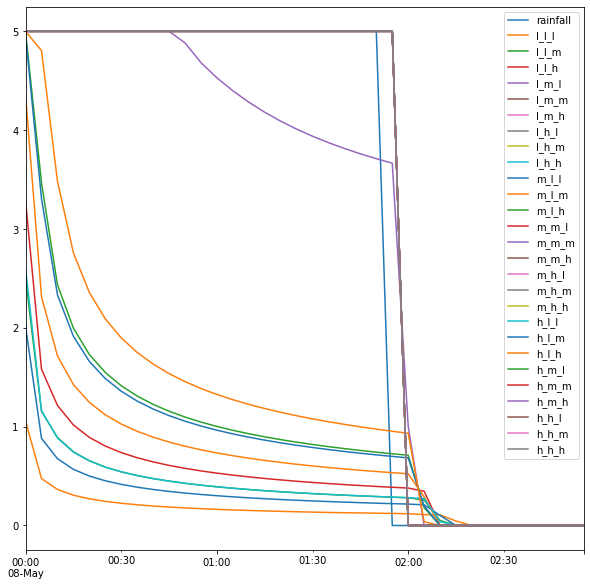

,rainfall,l_l_l,l_l_m,l_l_h,l_m_l,l_m_m,l_m_h,l_h_l,l_h_m,l_h_h,...,m_h_h,h_l_l,h_l_m,h_l_h,h_m_l,h_m_m,h_m_h,h_h_l,h_h_m,h_h_h
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,...,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,3.194444,0.164882,0.386450,0.519474,3.022959,3.333333,3.333333,3.333333,3.333333,3.333333,...,3.333333,0.389372,0.923759,1.235279,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333
std,2.435681,0.186917,0.451969,0.601750,2.156228,2.390457,2.390457,2.390457,2.390457,2.390457,...,2.390457,0.465404,1.007987,1.247111,2.390457,2.390457,2.390457,2.390457,2.390457,2.390457
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.091436,0.038173,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.029152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,0.137207,0.326762,0.441570,3.974374,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,0.327380,0.800319,1.094716,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
75%,5.000000,0.189337,0.455245,0.617021,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,0.455412,1.128361,1.560989,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,5.000000,1.055081,2.501853,3.287042,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,2.600928,4.959537,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [5]:
tmp_folder = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\tmp"
tmp_name = 'green_ampt_tmp.inp'
out_folder = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out'
# low, medium, and high values for each parameters
suction_list = [1.93, 7.3, 12.6] 
k_list = [0.01,2.37, 4.74]
imd_list = [2.4,14.4, 26.5]
dfs = sensitivity_analysis(tmp_folder, tmp_name, out_folder, suction_list, k_list, imd_list)
dfs.plot(figsize=(10, 10))
plt.show()
dfs.describe()

## Learn from the results

Now is the hard part. That is a lot of data to go through, and we need a more systematic way to learn from all this.

Let's first start with the typical values. 

Let's compare the 4 time sereis below,

- l_l_l: use low values for all 3 parameters
- h_h_h: use high values for all 3 parameters
- m_m_m: use middle values for all 3 parameters
- rainfall: the rainfall

Soil infiltration is reported in the same unit as rainfall in/hr. 

As we can see for the first 2hr when it is raining, after the rainfall stopped, the medium and high infiltration stayed as 5 in/hr for a little while.

This cannot be true, right? And this is one confusing part of SWMM results. For rainfall, each value reported is for the whole report time step, in other words, when drawing rainfall, it should be a step chart. Let's give that a try. Strongly recommend take some time learning how pandas works, it makes plotting time series so easy.

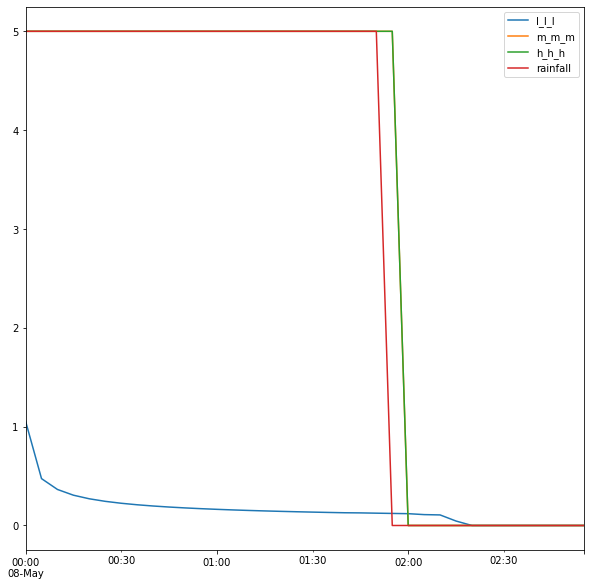

,l_l_l,m_m_m,h_h_h,rainfall
count,36.000000,36.000000,36.000000,36.000000
mean,0.164882,3.333333,3.333333,3.194444
std,0.186917,2.390457,2.390457,2.435681
min,0.000000,0.000000,0.000000,0.000000
25%,0.091436,0.000000,0.000000,0.000000
50%,0.137207,5.000000,5.000000,5.000000
75%,0.189337,5.000000,5.000000,5.000000
max,1.055081,5.000000,5.000000,5.000000


In [6]:
sub_dfs = dfs.loc[:, ['l_l_l', 'm_m_m', 'h_h_h', 'rainfall']]
sub_dfs.plot(figsize=(10, 10))
plt.show()

sub_dfs.describe()

Using a post postition step chart, the rainfall lines very nicely with the infiltration data. 

As we can see from the chart, for medium and high values, the rainfall is simply too small, it can take all that 1 in/hr through the 3 hr simulation. And we didn't really learn too much from it. So we need to narrow down the parameters so that we can get better results.

Let's limit the values using sandy loam, loam and silt loam, and that's what I'll do next week.

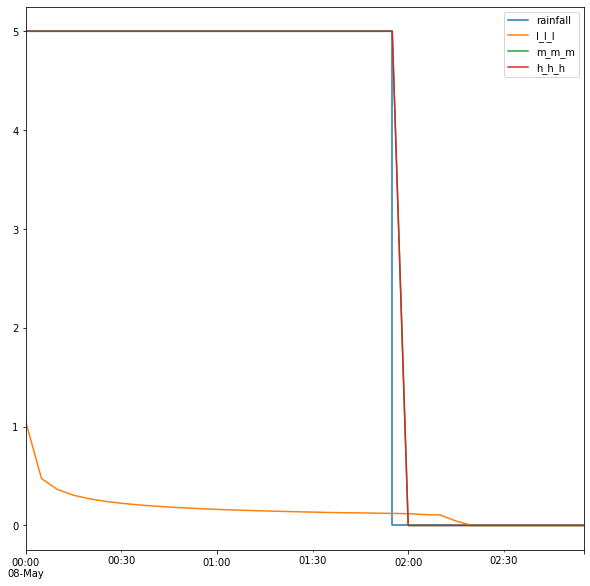

In [7]:
sub_dfs = dfs.loc[:, ['l_l_l', 'm_m_m', 'h_h_h', 'rainfall']]
rainfall = sub_dfs['rainfall']
del sub_dfs['rainfall']
ax = rainfall.plot(drawstyle="steps-post", label='rainfall')
sub_dfs.plot(ax=ax, figsize=(10,10))
plt.legend()